In [90]:
import gc
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [91]:
SEED = 11
FOLDS = 5
ESTIMATORS = 100
SCORING = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True, average='macro')
TARGET = 'Target'

CATEGORICALS = {'Var19','Var23','Var26','Var27','Var68','Var93','Var133','Var134','Var162'}
CONTINUOUS_FEATURES = {'Var4','Var7','Var9','Var10','Var13','Var14','Var20','Var21','Var22','Var24','Var25',
'Var28','Var35','Var44','Var54','Var55','Var56','Var57','Var72','Var73','Var81','Var82','Var83','Var84','Var85',
'Var95','Var114','Var129','Var130','Var131','Var136','Var161','Var163'}
ORDINAL_FEATURES = {'Var5','Var29','Var30','Var32','Var34','Var45','Var46','Var47','Var48','Var49','Var50','Var51',
'Var60','Var70','Var71','Var74','Var75','Var76','Var77','Var78','Var79','Var80','Var86','Var87','Var88','Var89',
'Var90','Var91','Var105','Var106','Var107','Var108','Var109','Var110','Var111','Var112','Var113','Var116','Var117',
'Var118','Var119','Var120','Var121','Var122','Var123','Var124','Var125','Var135','Var143'}
DUMMY_FEATURES = {'Var6','Var8','Var11','Var12','Var15','Var16','Var17','Var18','Var31','Var33','Var36','Var37',
'Var38','Var39','Var40','Var41','Var42','Var43','Var52','Var53','Var58','Var59','Var61','Var62','Var63','Var64',
'Var65','Var66','Var67','Var69','Var92','Var94','Var96','Var97','Var98','Var99','Var100','Var101','Var102','Var103',
'Var104','Var126','Var127','Var128','Var132','Var137','Var138','Var139','Var140','Var141','Var142','Var144','Var145',
'Var146','Var147','Var148','Var149','Var150','Var151','Var152','Var153','Var154','Var155','Var156','Var157','Var158',
'Var159','Var160'}
#FEATURES = [f'Var{i}' for i in range(4, 164)]
FEATURES = CATEGORICALS | CONTINUOUS_FEATURES | ORDINAL_FEATURES | DUMMY_FEATURES

In [92]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [93]:
#data = pd.read_csv(f'data/ex2.csv', index_col='ID', dtype=COLUMNS, usecols=list(COLUMNS.keys()))
data = pd.read_csv(f'data/ex2.csv', index_col='ID')
data.drop(columns='Unnamed: 0', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13015 entries, 1 to 13015
Columns: 162 entries, Fold to Var163
dtypes: float64(19), int64(142), object(1)
memory usage: 16.2+ MB


In [94]:
train = data[data['Fold'] == 'IS'].copy()
train.drop(columns='Fold', inplace=True)
train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8242 entries, 1 to 8725
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  8242 non-null   int64  
 1   Var4    8242 non-null   int64  
 2   Var5    8242 non-null   int64  
 3   Var6    8242 non-null   int64  
 4   Var7    8242 non-null   float64
 5   Var8    8242 non-null   int64  
 6   Var9    8242 non-null   float64
 7   Var10   8242 non-null   int64  
 8   Var11   8242 non-null   int64  
 9   Var12   8242 non-null   int64  
 10  Var13   8242 non-null   float64
 11  Var14   8242 non-null   float64
 12  Var15   8242 non-null   int64  
 13  Var16   8242 non-null   int64  
 14  Var17   8242 non-null   int64  
 15  Var18   8242 non-null   int64  
 16  Var19   8242 non-null   int64  
 17  Var20   8242 non-null   int64  
 18  Var21   8242 non-null   int64  
 19  Var22   8242 non-null   int64  
 20  Var23   8242 non-null   int64  
 21  Var24   8242 non-null   float64
 22 

In [95]:
test = data[data['Fold'] == 'OS'].copy()
test.drop(columns='Fold', inplace=True)
test.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 101 to 13015
Data columns (total 161 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  4773 non-null   int64  
 1   Var4    4773 non-null   int64  
 2   Var5    4773 non-null   int64  
 3   Var6    4773 non-null   int64  
 4   Var7    4773 non-null   float64
 5   Var8    4773 non-null   int64  
 6   Var9    4773 non-null   float64
 7   Var10   4773 non-null   int64  
 8   Var11   4773 non-null   int64  
 9   Var12   4773 non-null   int64  
 10  Var13   4773 non-null   float64
 11  Var14   4773 non-null   float64
 12  Var15   4773 non-null   int64  
 13  Var16   4773 non-null   int64  
 14  Var17   4773 non-null   int64  
 15  Var18   4773 non-null   int64  
 16  Var19   4773 non-null   int64  
 17  Var20   4773 non-null   int64  
 18  Var21   4773 non-null   int64  
 19  Var22   4773 non-null   int64  
 20  Var23   4773 non-null   int64  
 21  Var24   4773 non-null   float64
 

In [96]:
del data
gc.collect()

23691

In [97]:
train[TARGET].value_counts(normalize=True)

0    0.975855
1    0.024145
Name: Target, dtype: float64

In [98]:
test[TARGET].value_counts(normalize=True)

0    0.98282
1    0.01718
Name: Target, dtype: float64

In [99]:
def encode(df, col, encoder):
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()


cols = CATEGORICALS | DUMMY_FEATURES
for col in tqdm(cols):
    encoder = dict(train[col].value_counts(normalize=True))
    encode(train, col, encoder)
    encode(test, col, encoder)

100%|██████████| 77/77 [00:00<00:00, 302.58it/s]


In [100]:
train[cols].head()

,Var162,Var52,Var58,Var154,Var27,Var155,Var102,Var142,Var156,Var140,...,Var98,Var99,Var15,Var37,Var68,Var101,Var93,Var145,Var39,Var126
ID,,,,,,,,,,,,,,,,,,,,,
1,0.366416,0.94795,0.993934,0.96348,0.831716,0.99272,0.765348,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.219607,0.742417,0.917374,0.947828,0.76098,0.951347
2,0.346518,0.05205,0.993934,0.96348,0.168284,0.99272,0.765348,0.145838,0.975977,0.73999,...,0.190245,0.14596,0.290221,0.99818,0.354647,0.742417,0.043921,0.052172,0.23902,0.951347
3,0.366416,0.94795,0.993934,0.96348,0.831716,0.99272,0.765348,0.145838,0.975977,0.73999,...,0.190245,0.14596,0.709779,0.99818,0.264742,0.742417,0.917374,0.947828,0.76098,0.951347
4,0.050716,0.94795,0.993934,0.96348,0.168284,0.99272,0.765348,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.028512,0.742417,0.917374,0.947828,0.23902,0.951347
5,0.046591,0.94795,0.993934,0.96348,0.831716,0.99272,0.234652,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.071099,0.257583,0.917374,0.947828,0.76098,0.951347


In [101]:
test[cols].head()

,Var162,Var52,Var58,Var154,Var27,Var155,Var102,Var142,Var156,Var140,...,Var98,Var99,Var15,Var37,Var68,Var101,Var93,Var145,Var39,Var126
ID,,,,,,,,,,,,,,,,,,,,,
101,0.037370,0.94795,0.993934,0.96348,0.831716,0.99272,0.234652,0.854162,0.975977,0.73999,...,0.190245,0.14596,0.709779,0.99818,0.028512,0.257583,0.917374,0.947828,0.76098,0.951347
1297,0.149357,0.94795,0.993934,0.96348,0.831716,0.99272,0.765348,0.854162,0.975977,0.26001,...,0.809755,0.85404,0.709779,0.99818,0.354647,0.742417,0.917374,0.947828,0.23902,0.951347
1505,0.346518,0.94795,0.993934,0.96348,0.831716,0.99272,0.765348,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.071099,0.742417,0.917374,0.947828,0.76098,0.951347
1527,0.366416,0.94795,0.993934,0.96348,0.831716,0.99272,0.234652,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.264742,0.257583,0.917374,0.947828,0.76098,0.951347
1528,0.149357,0.94795,0.993934,0.96348,0.831716,0.99272,0.765348,0.854162,0.975977,0.73999,...,0.809755,0.85404,0.709779,0.99818,0.354647,0.742417,0.917374,0.947828,0.76098,0.951347


# Feature Selection

KS Test

In [102]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = 0.1
sample = train.sample(frac=1)
mid = int(len(sample) / 2)
original = set(FEATURES)
FEATURES = _select_features(sample[:mid], sample[mid:], FEATURES, ALPHA)

100%|██████████| 159/159 [00:00<00:00, 640.88it/s]


In [103]:
dropped = original - set(FEATURES)
print(f"""
Keep {len(FEATURES)} features={FEATURES}

Drop {len(dropped)} features={dropped}
""")


Keep 154 features=['Var162', 'Var117', 'Var52', 'Var58', 'Var27', 'Var102', 'Var73', 'Var24', 'Var106', 'Var140', 'Var35', 'Var69', 'Var122', 'Var49', 'Var100', 'Var147', 'Var55', 'Var127', 'Var161', 'Var137', 'Var159', 'Var108', 'Var5', 'Var61', 'Var81', 'Var83', 'Var150', 'Var112', 'Var158', 'Var65', 'Var56', 'Var31', 'Var44', 'Var92', 'Var82', 'Var63', 'Var104', 'Var4', 'Var18', 'Var79', 'Var57', 'Var135', 'Var111', 'Var60', 'Var103', 'Var119', 'Var72', 'Var86', 'Var124', 'Var66', 'Var38', 'Var141', 'Var76', 'Var25', 'Var139', 'Var146', 'Var14', 'Var54', 'Var125', 'Var163', 'Var95', 'Var43', 'Var17', 'Var41', 'Var98', 'Var99', 'Var68', 'Var78', 'Var129', 'Var28', 'Var39', 'Var126', 'Var143', 'Var87', 'Var105', 'Var118', 'Var154', 'Var10', 'Var155', 'Var7', 'Var142', 'Var51', 'Var156', 'Var11', 'Var70', 'Var23', 'Var153', 'Var47', 'Var148', 'Var96', 'Var151', 'Var64', 'Var160', 'Var74', 'Var116', 'Var32', 'Var48', 'Var84', 'Var42', 'Var89', 'Var90', 'Var26', 'Var88', 'Var157', 'Var1

In [104]:
y_train = train[TARGET]
x_train = train[FEATURES]

In [105]:
# scale_pos_weight is the ratio of number of negative class to the positive class.
model = lgb.LGBMClassifier(n_estimators=ESTIMATORS, reg_alpha=1, scale_pos_weight=49)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [31],
    'model__min_child_samples': [20],
    'model__colsample_bytree': [0.5]
}
# Defaults to StratifiedKFold
lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
lgbm.fit(x_train, y_train)
best_score = lgbm.best_score_
best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
print(f"""LGBM
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(lgbm.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.head()

LGBM
best params={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__num_leaves': 31}
best score=0.653, std=0.075



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.190203,0.023155,0.007059,0.00123,0.5,0.01,20,31,"{'model__colsample_bytree': 0.5, 'model__learn...",0.544065,0.620727,0.625233,0.756188,0.716884,0.652619,0.075376


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

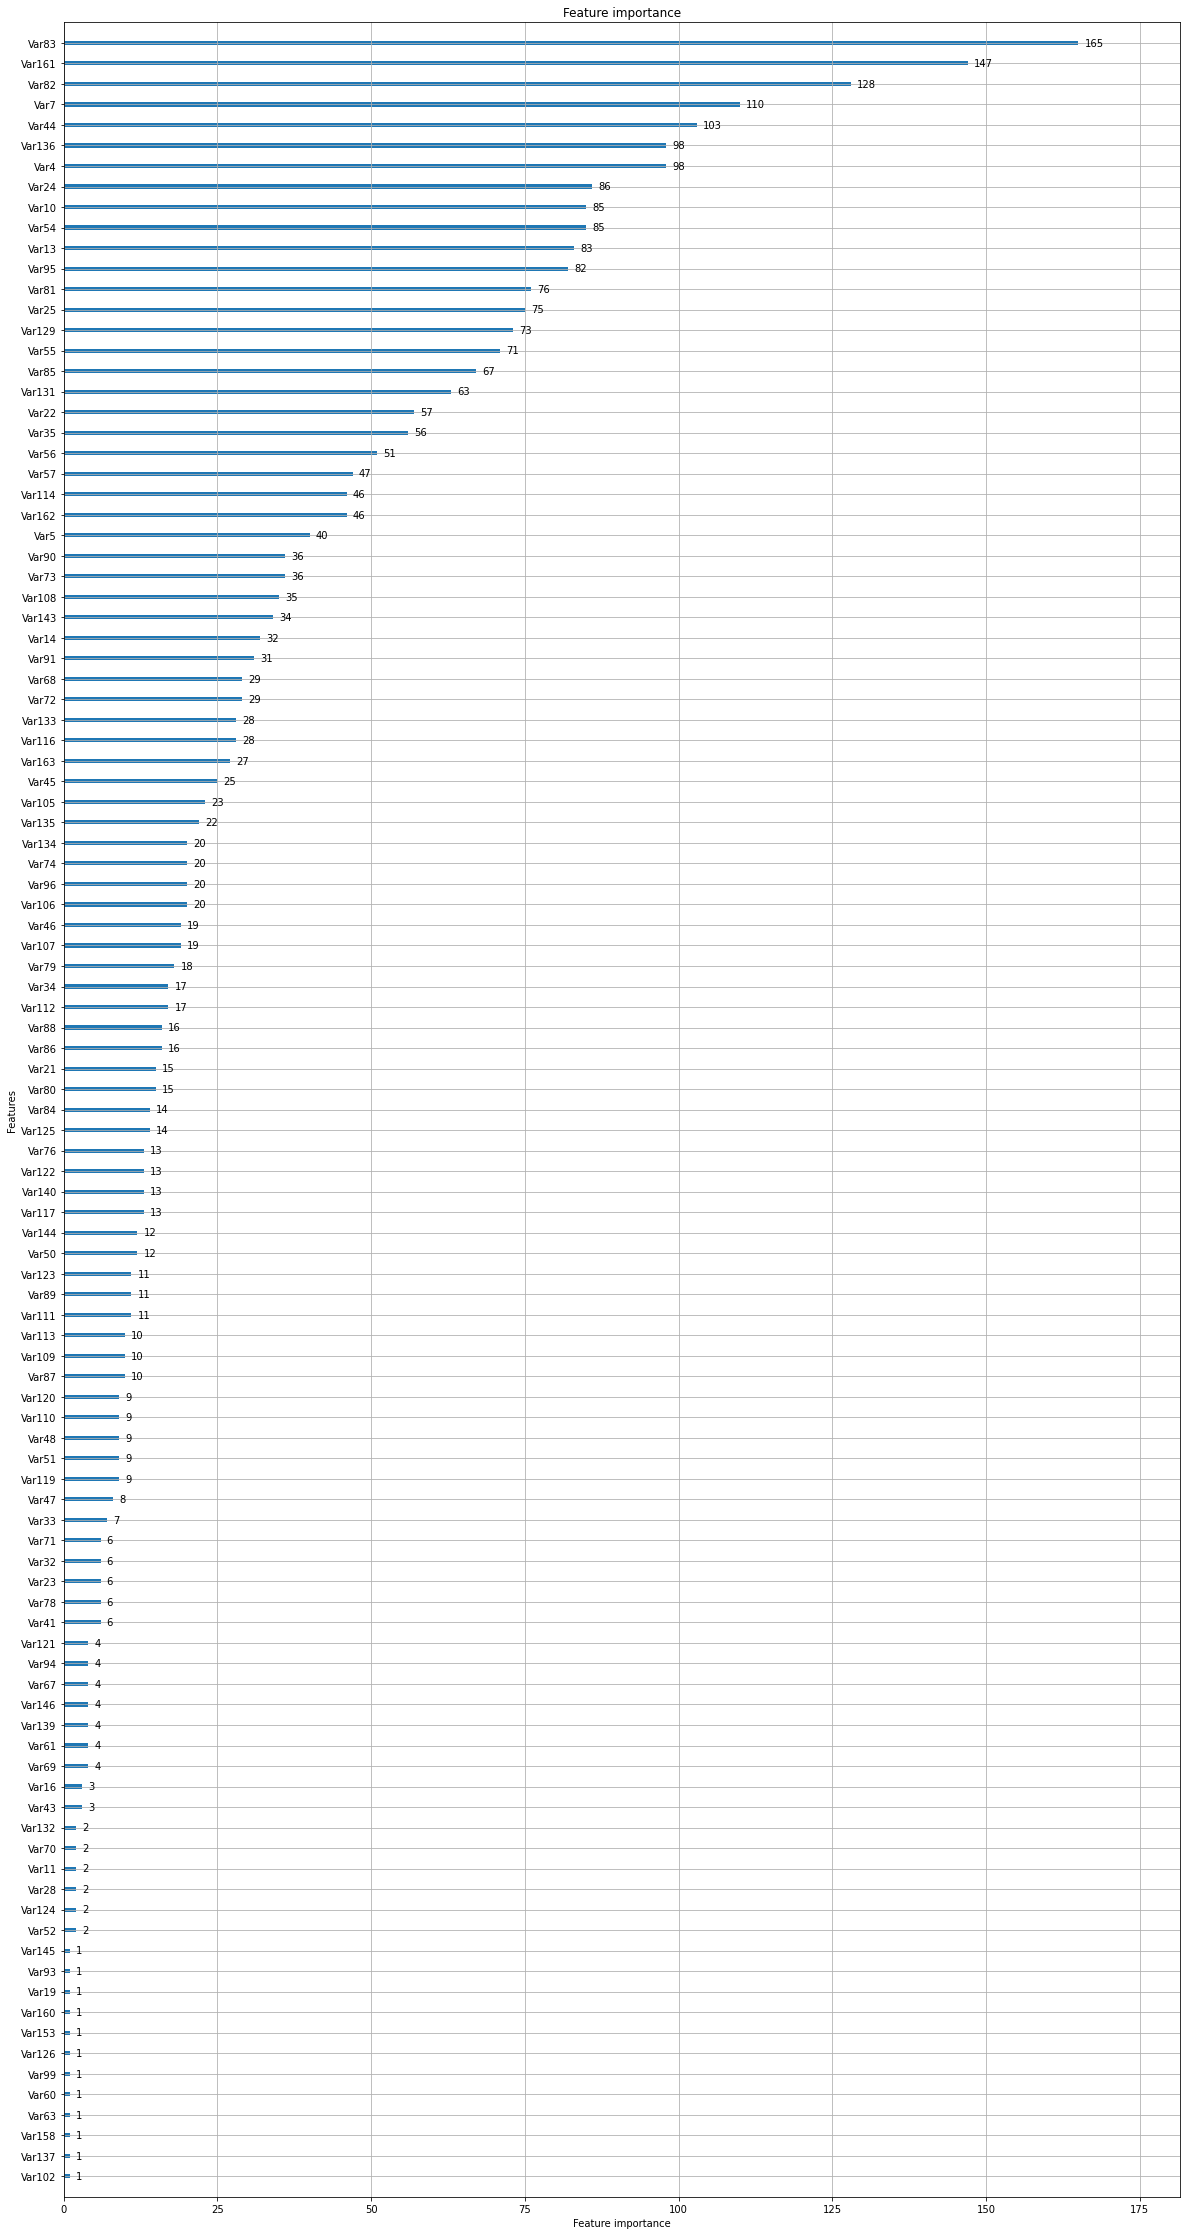

In [106]:
lgb.plot_importance(lgbm.best_estimator_['model'], figsize=(20, 40))

In [107]:
model = RandomForestClassifier(n_estimators=ESTIMATORS, class_weight='balanced_subsample')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__min_samples_leaf': [20],
    'model__max_features': ['sqrt']
}
# Defaults to StratifiedKFold
rf = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
rf.fit(x_train, y_train)
best_score = rf.best_score_
best_score_std = rf.cv_results_['std_test_score'][rf.best_index_]
print(f"""Random Forest
best params={repr(rf.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
""")
res = pd.DataFrame.from_dict(rf.cv_results_)
res.set_index('rank_test_score', inplace=True)
res.head()

Random Forest
best params={'model__max_features': 'sqrt', 'model__min_samples_leaf': 20}
best score=0.686, std=0.087



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_features,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,0.679523,0.014508,0.021458,0.000458,sqrt,20,"{'model__max_features': 'sqrt', 'model__min_sa...",0.574627,0.61574,0.752227,0.812174,0.67727,0.686407,0.086858


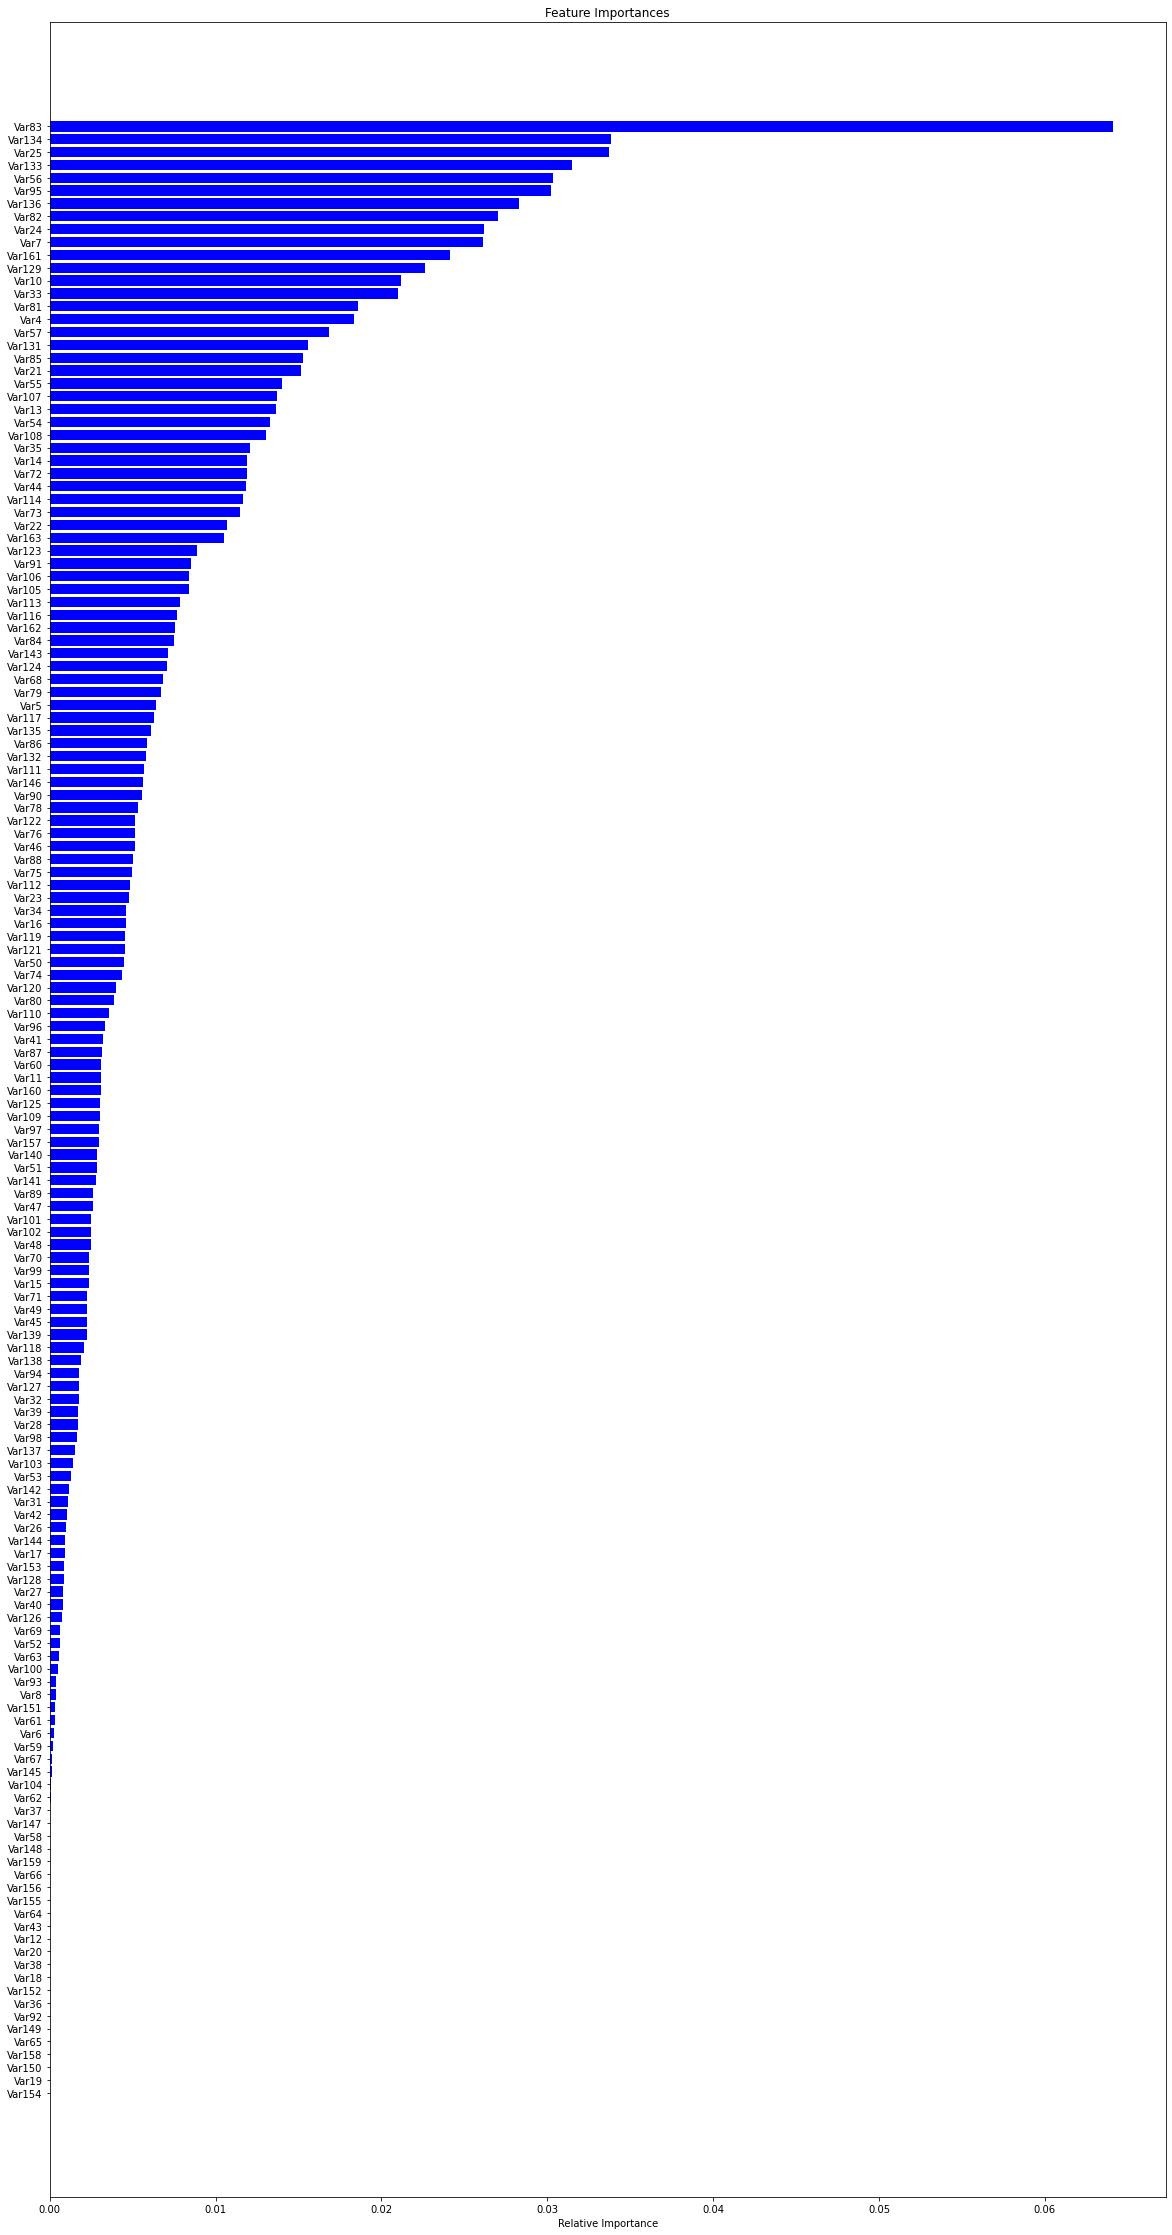

In [108]:
importances = rf.best_estimator_['model'].feature_importances_
plt.figure(figsize=(20,40))
plt.title("Feature importances")
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()